# Image Analysis And Recognition
---
* <a href='#hw1'>Homework.1 - Image Averaging</a>
* <a href='#hw2'>Homework.2 - Imgae Stitching</a>
* <a href='#hw3'>Homework.3 - Edge Detection</a>

# <a name='hw1'>Homework.1 - Image Averaging</a>
---

In [20]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from skimage.data import camera
from skimage.filters import sobel
from skimage.util import img_as_ubyte

In [4]:
def sp_noise(image,prob):
    '''
    salt and pepper noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def gasuss_noise(image, mean=0, var=0.001):
    ''' 
    gaussian noise
    '''
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    #cv.imshow("gasuss", out)
    return out

def avg_image(image_list):
    return np.sum(image_list, 0)/len(image_list)

def med_image(image_list):
    return np.median(image_list, 0)

def print_image(image):
    fig = plt.figure()
    fig.set_size_inches((10, 6))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

In [3]:
img = cv2.imread('101view.jpg')[:,:,::-1]

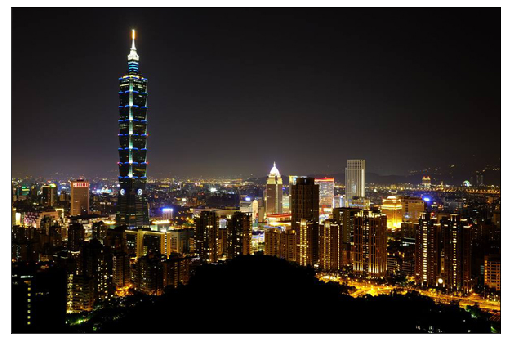

In [4]:
print_image(img)

In [5]:
img_list = [sp_noise(img, 0.001*i) for i in range(1,4)]

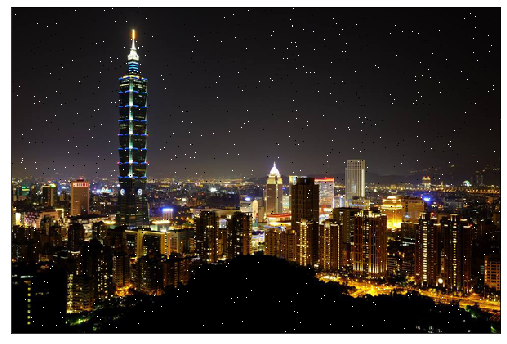

In [6]:
print_image(img_list[2])

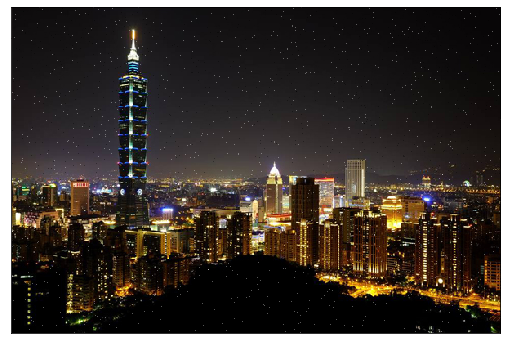

In [7]:
print_image(avg_image(img_list).astype(np.uint8))

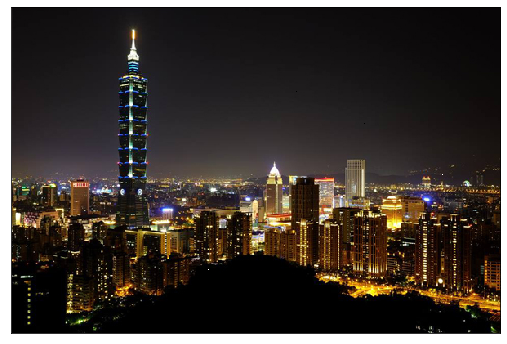

In [8]:
print_image(med_image(img_list).astype(np.uint8))

# <a name='hw2'>Homework.2 - Image Stitching</a>
---

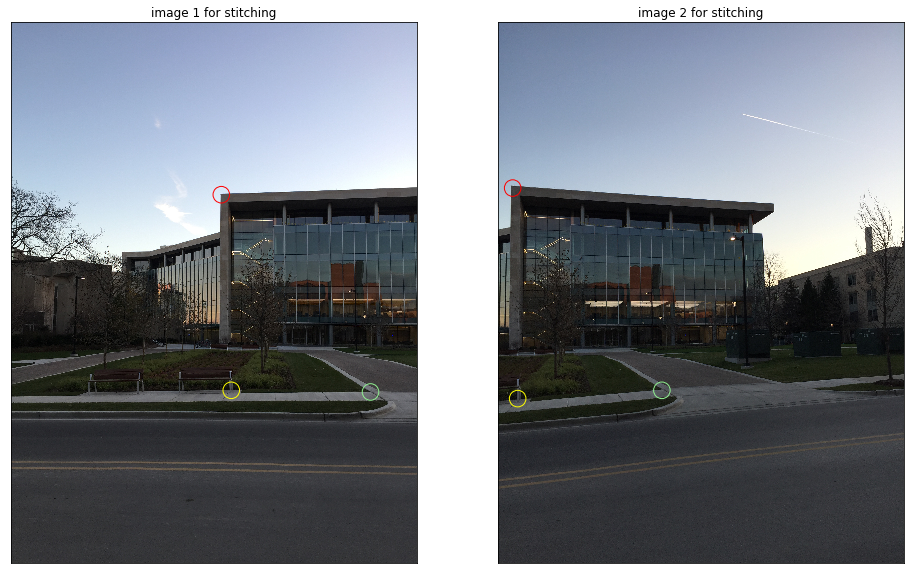

In [9]:
img_s1 = cv2.imread('stitch1.jpg')[:,:,::-1]
img_s2 = cv2.imread('stitch2.jpg')[:,:,::-1]

fig = plt.figure(figsize=(16,10))

circle11 = plt.Circle((1270, 1040), 50, color='r', fill=False)
circle12 = plt.Circle((1330, 2220), 50, color='yellow', fill=False)
circle13 = plt.Circle((2170, 2230), 50, color='lightgreen', fill=False)
ax1 = fig.add_subplot(121)
plt.imshow(img_s1)
plt.xticks([])
plt.yticks([])
ax1.add_artist(circle11)
ax1.add_artist(circle12)
ax1.add_artist(circle13)
plt.title("image 1 for stitching")
    
circle21 = plt.Circle((90, 1000), 50, color='r', fill=False)
circle22 = plt.Circle((120, 2270), 50, color='yellow', fill=False)
circle23 = plt.Circle((990, 2220), 50, color='lightgreen', fill=False)
ax2 = fig.add_subplot(122)
plt.imshow(img_s2)
plt.xticks([])
plt.yticks([])
ax2.add_artist(circle21)
ax2.add_artist(circle22)
ax2.add_artist(circle23)
plt.title("image 2 for stitching")
plt.show()

In [10]:
img_s2.shape

(3264, 2448, 3)

list equations:
1. 1270 = t11 * 90 + t21 * 1000 + t31
2. 1040 = t12 * 90 + t22 * 1000 + t32
3. 1330 = t11 * 120 + t21 * 2270 + t31
4. 2220 = t12 * 120 + t22 * 2270 + t32
5. 2170 = t11 * 990 + t21 * 2220 + t31
6. 2230 = t12 * 990 + t22 * 2220 + t32

In [11]:
primary = np.array([[1270, 1040], [1330, 2220], [2170, 2230]], dtype=np.float64)

secondary = np.array([[90, 1000], [120, 2270], [990, 2220]], dtype=np.float64)

In [12]:
def get_affine(from_p, to_p):
    cm = np.array([[from_p[0,0], from_p[0,1], 1], [from_p[1,0], from_p[1,1], 1], [from_p[2,0], from_p[2,1], 1]])
    b_tx1 = np.array([to_p[0,0], to_p[1,0], to_p[2,0]])
    b_tx2 = np.array([to_p[0,1], to_p[1,1], to_p[2,1]])
    Af_tx1 = np.linalg.solve(cm, b_tx1)
    Af_tx2 = np.linalg.solve(cm, b_tx2)
    return np.array([[Af_tx1[0], Af_tx2[0], 0], [Af_tx1[1], Af_tx2[1], 0], [Af_tx1[2], Af_tx2[2], 1]])

In [13]:
Af21 = get_affine(secondary, primary)

In [14]:
Af12 = get_affine(primary, secondary)

In [15]:
np.dot([90, 1000, 1], Af21)

array([1.27e+03, 1.04e+03, 1.00e+00])

### 宣告底色全黑畫布

In [16]:
canvas = np.zeros([4000, 5000, 3], dtype=np.uint8)

In [17]:
canvas[500:3764, 500:2948, :] = img_s1

### 把img_s2四個角落找出來

In [27]:
c1 = np.dot([0, 0, 1], Af21) #左上角
c2 = np.dot([0, 3264, 1], Af21) #右上角
c3 = np.dot([2448, 0, 1], Af21) #左下角
c4 = np.dot([2448, 3264, 1], Af21) #右下角

In [19]:
p1 = np.array([c1[0], c1[1]]) + 500
p2 = np.array([c2[0], c2[1]]) + 500
p3 = np.array([c3[0], c3[1]]) + 500
p4 = np.array([c4[0], c4[1]]) + 500

In [37]:
for i in range(900,3500):
    for j in range(2948,3900):
        #canvas[i, j, :] = 255
        ctx = np.dot([j-500, i-500, 1], Af12)
        canvas[i, j, :] = img_s2[int(ctx[1]), int(ctx[0]), :]

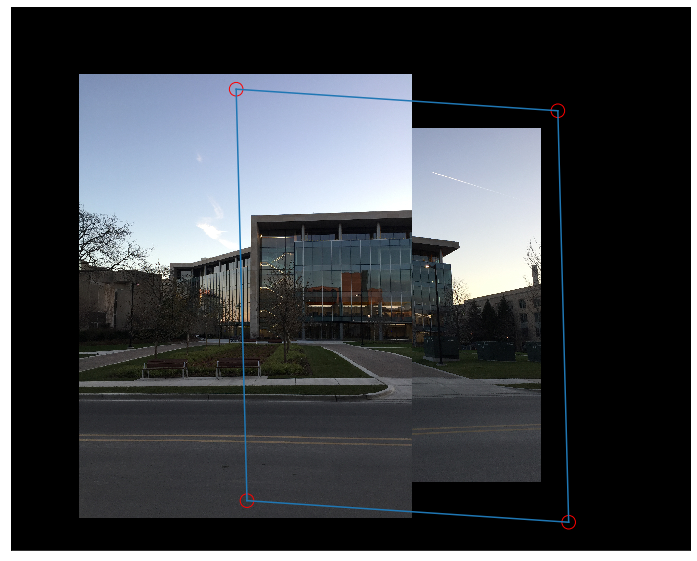

In [39]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
plt.xticks([])
plt.yticks([])
circle1 = plt.Circle((p1[0], p1[1]), 50, color='r', fill=False)
circle2 = plt.Circle((p2[0], p2[1]), 50, color='r', fill=False)
circle3 = plt.Circle((p3[0], p3[1]), 50, color='r', fill=False)
circle4 = plt.Circle((p4[0], p4[1]), 50, color='r', fill=False)
ax.add_line(mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]]))
ax.add_line(mlines.Line2D([p2[0],p4[0]], [p2[1],p4[1]]))
ax.add_line(mlines.Line2D([p4[0],p3[0]], [p4[1],p3[1]]))
ax.add_line(mlines.Line2D([p3[0],p1[0]], [p3[1],p1[1]]))
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)
ax.add_artist(circle4)
plt.imshow(canvas)

# <a name='hw3'>Homework.3 - Edge Detection</a>
---

In [34]:
img_cvo = cv2.imread('canon_lense.jpg')[:,:,::-1]

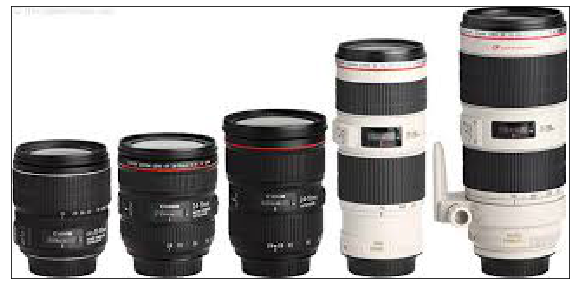

In [35]:
print_image(img_cvo)

In [123]:
sobel_h = np.array([[1, 2, 1], 
                    [0, 0, 0], 
                    [-1, -2, -1]])

sobel_v = np.array([[1, 0, -1], 
                    [2, 0, -2], 
                    [1, 0, -1]])

avg_flt = np.array([[1, 1, 1],
                   [1, 1, 1],
                   [1, 1, 1]])

sharp_flt = np.array([[1, 2, 1],
                     [2, 4, 2],
                     [1, 2, 1]])

In [91]:
def convo(image, filt):
    result = np.zeros_like(image)
    uh, uw, uc = image.shape
    for c in range(uc):
        for i in range(1,uh-1):
            for j in range(1,uw-1):
                #print(i, j, c, sum(sum(image[i-1:i+2, j-1:j+2, c] * filt)))
                result[i, j, c] = sum(sum(image[i-1:i+2, j-1:j+2, c] * filt)) / 9

    return result

In [125]:
img_cvo = cv2.copyMakeBorder(img_cvo, 1, 1, 1, 1, cv2.BORDER_DEFAULT)

In [150]:
img_blur = convo(img_cvo, avg_flt)
img_final = convo(img_blur, sharp_flt)
img_final = img_cvo - img_final

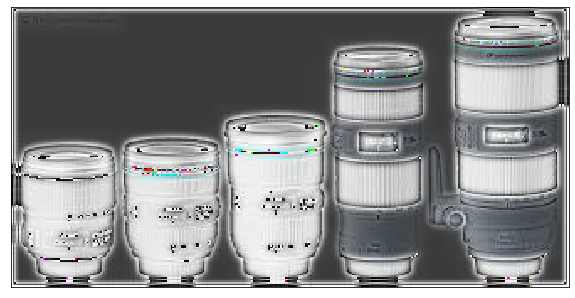

In [145]:
print_image(img_final)

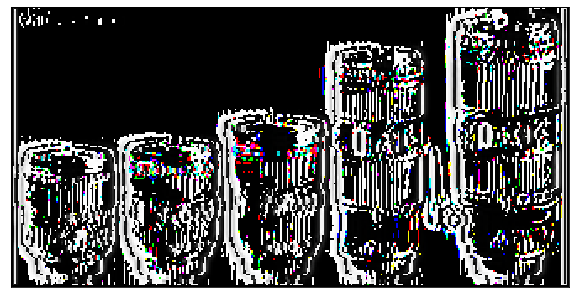

In [143]:
img_v = convo(img_final, sobel_v)
print_image(img_v)

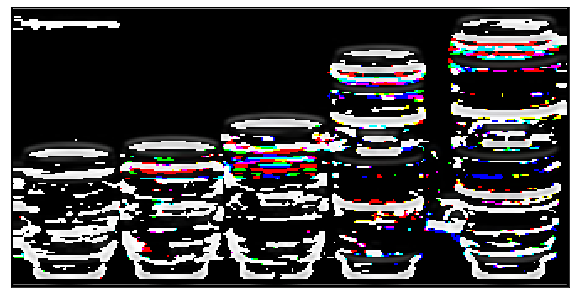

In [136]:
img_h = convo(img_blur, sobel_h)
print_image(img_h)

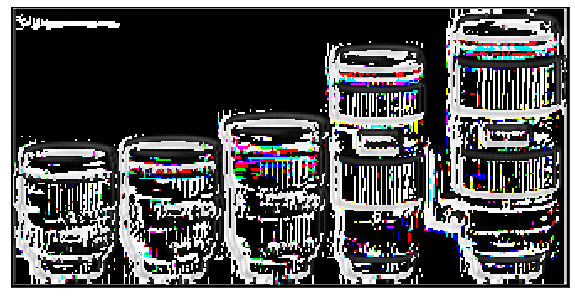

In [137]:
print_image(img_v + img_h)

In [61]:
img_sbo_r = sobel(img_cvo[:,:,0])[:, :, np.newaxis]
img_sbo_g = sobel(img_cvo[:,:,1])[:, :, np.newaxis]
img_sbo_b = sobel(img_cvo[:,:,2])[:, :, np.newaxis]

In [62]:
img_sbo_r.shape

(157, 322, 1)

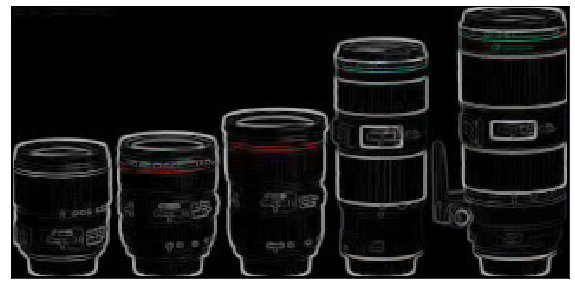

In [63]:
print_image(np.concatenate((img_sbo_r, img_sbo_g, img_sbo_b), axis=2))